# Comparing Ecker Data with New Cathode and Anode Chemistry

Improved diffusion coefficient formulae

In [1]:
%pip install pybamm -q    # install PyBaMM if it is not installed
import pybamm
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as skm
os.chdir(pybamm.__path__[0]+'/..')

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.
Note: you may need to restart the kernel to use updated packages.


In [2]:
voltage_data_1C = pd.read_csv("pybamm/input/discharge_data/Ecker_1C.csv", header=None).to_numpy()
voltage_data_5C = pd.read_csv("pybamm/input/discharge_data/Ecker_5C.csv", header=None).to_numpy()

In [3]:
# choose DFN
model1 = pybamm.lithium_ion. DFN()
# choose SPMe
model2 = pybamm.lithium_ion. SPMe()

In [4]:
chemistry_new = pybamm.parameter_sets.Ecker2015_v2

## Comparing New Chemistry with Old Chemistry (Parameters Unchanged)

Parameter set 1: old chemistry, unchanged parameters

Parameter set 2: new chemistry, unchanged parameters

In [5]:
parameter_values1s = pybamm.ParameterValues(chemistry=chemistry_new)
parameter_values1s.update({"Current function [A]": "[input]"})

In [6]:
parameter_values2s = pybamm.ParameterValues(chemistry=chemistry_new)
parameter_values2s.update({"Current function [A]": "[input]"})
parameter_values2s.update({"Negative electrode diffusivity [m2.s-1]": "[function]graphite_diffusivity_Ecker2015_up"},
                        path="pybamm/input/parameters/lithium-ion/anodes/" + chemistry_new['anode'])

In [7]:
parameter_values0s = pybamm.ParameterValues(chemistry=chemistry_new)
parameter_values0s.update({"Current function [A]": "[input]"})
parameter_values0s.update({"Negative electrode diffusivity [m2.s-1]": "[function]graphite_diffusivity_Ecker2015_original"},
                        path="pybamm/input/parameters/lithium-ion/anodes/" + chemistry_new['anode'])

In [8]:
parameter_values3s = pybamm.ParameterValues(chemistry=chemistry_new)
parameter_values3s.update({"Current function [A]": "[input]"})
parameter_values3s.update({"Negative electrode diffusivity [m2.s-1]": "[function]graphite_diffusivity_Ecker2015_4"},
                        path="pybamm/input/parameters/lithium-ion/anodes/" + chemistry_new['anode'])

In [9]:
var = pybamm.standard_spatial_vars
var_pts_n1 = {
    var.x_n: int(parameter_values0s.evaluate(model2.param.L_n / 1e-6)),
    var.x_s: int(parameter_values0s.evaluate(model2.param.L_s / 1e-6)),
    var.x_p: int(parameter_values0s.evaluate(model2.param.L_p / 1e-6)),
    var.r_n: int(parameter_values0s.evaluate(model2.param.R_n / 1e-7)),
    var.r_p: int(parameter_values0s.evaluate(model2.param.R_p / 1e-7)),
}

In [10]:
sim_So = pybamm.Simulation(model1, parameter_values=parameter_values0s, var_pts=var_pts_n1)
sim_Sex = pybamm.Simulation(model1, parameter_values=parameter_values1s, var_pts=var_pts_n1)
sim_Sup = pybamm.Simulation(model1, parameter_values=parameter_values2s, var_pts=var_pts_n1)
sim_S4 = pybamm.Simulation(model2, parameter_values=parameter_values3s, var_pts=var_pts_n1)

In [11]:
C_rates = [1, 5]  # C-rates to solve for
capacity = parameter_values1s["Cell capacity [A.h]"]
t_evals = [
    np.linspace(0, 3800, 100), 
    np.linspace(0, 720, 100)
] # times to return the solution at
solutions_Sex = [None] * len(C_rates)  # empty list that will hold solutions

# loop over C-rates
for i, C_rate in enumerate(C_rates):
    current = C_rate * capacity
    sim_Sex.solve(t_eval=t_evals[i], solver=pybamm.CasadiSolver(mode="fast"),inputs={"Current function [A]": current})
    solutions_Sex[i] = sim_Sex.solution

In [12]:
C_rates = [1, 5]  # C-rates to solve for
capacity = parameter_values2s["Cell capacity [A.h]"]
t_evals = [
    np.linspace(0, 3800, 100), 
    np.linspace(0, 720, 100)
] # times to return the solution at
solutions_Sup = [None] * len(C_rates)  # empty list that will hold solutions

# loop over C-rates
for i, C_rate in enumerate(C_rates):
    current = C_rate * capacity
    sim_Sup.solve(t_eval=t_evals[i], solver=pybamm.CasadiSolver(mode="fast"),inputs={"Current function [A]": current})
    solutions_Sup[i] = sim_Sup.solution

In [13]:
C_rates = [1, 5]  # C-rates to solve for
capacity = parameter_values0s["Cell capacity [A.h]"]
t_evals = [
    np.linspace(0, 3800, 100), 
    np.linspace(0, 720, 100)
] # times to return the solution at
solutions_So = [None] * len(C_rates)  # empty list that will hold solutions

# loop over C-rates
for i, C_rate in enumerate(C_rates):
    current = C_rate * capacity
    sim_So.solve(t_eval=t_evals[i], solver=pybamm.CasadiSolver(mode="fast"),inputs={"Current function [A]": current})
    solutions_So[i] = sim_So.solution

In [14]:
C_rates = [1, 5]  # C-rates to solve for
capacity = parameter_values3s["Cell capacity [A.h]"]
t_evals = [
    np.linspace(0, 3800, 100), 
    np.linspace(0, 720, 100)
] # times to return the solution at
solutions_S4 = [None] * len(C_rates)  # empty list that will hold solutions

# loop over C-rates
for i, C_rate in enumerate(C_rates):
    current = C_rate * capacity
    sim_S4.solve(t_eval=t_evals[i], solver=pybamm.CasadiSolver(mode="fast"),inputs={"Current function [A]": current})
    solutions_S4[i] = sim_S4.solution

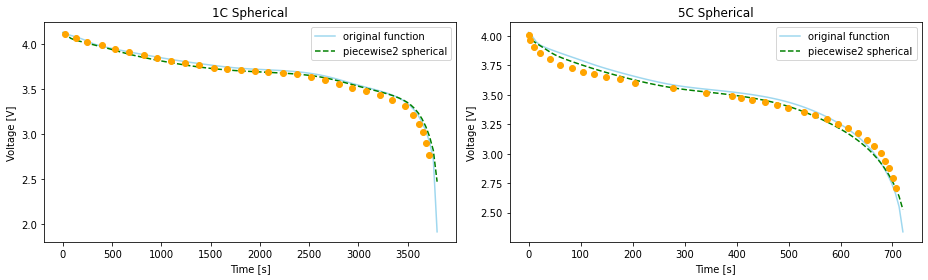

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

# plot the 1C Spherical results
t_sol_So = solutions_So[0]["Time [s]"].entries
t_sol_Sup = solutions_Sup[0]["Time [s]"].entries
t_sol_Sex = solutions_Sex[0]["Time [s]"].entries
ax1.plot(t_sol_So, solutions_So[0]["Terminal voltage [V]"](t_sol_So), label="original function", alpha=0.8, color="skyblue")
#ax1.plot(t_sol_Sex, solutions_Sex[0]["Terminal voltage [V]"](t_sol_Sex), label="piecewise1", linestyle="--", color="brown")
ax1.plot(t_sol_Sup, solutions_Sup[0]["Terminal voltage [V]"](t_sol_Sup), label="piecewise2 spherical", linestyle="--", color="green")
ax1.plot(voltage_data_1C[:,0], voltage_data_1C[:,1], "o", color='orange')
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Voltage [V]")
ax1.set_title("1C Spherical")
ax1.legend(loc="best")

# plot the 5C Spherical results
t_sol_So = solutions_So[1]["Time [s]"].entries
t_sol_Sup = solutions_Sup[1]["Time [s]"].entries
t_sol_Sex = solutions_Sex[1]["Time [s]"].entries
ax2.plot(t_sol_So, solutions_So[1]["Terminal voltage [V]"](t_sol_So), label="original function", alpha=0.8, color="skyblue")
#ax2.plot(t_sol_Sex, solutions_Sex[1]["Terminal voltage [V]"](t_sol_Sex), label="piecewise1",linestyle="--", color="brown")
ax2.plot(t_sol_Sup, solutions_Sup[1]["Terminal voltage [V]"](t_sol_Sup), label="piecewise2 spherical", linestyle="--", color="green")
ax2.plot(voltage_data_5C[:,0], voltage_data_5C[:,1], "o", color='orange')
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Voltage [V]")
ax2.set_title("5C Spherical")
ax2.legend(loc="best")

plt.tight_layout()
#plt.savefig('adjust fit4 exponential spherical')
plt.show()

2020-08-21 11:04:19,906 - [WARNING] processed_variable.__call__(510): Calling variable outside interpolation range (returns 'nan')


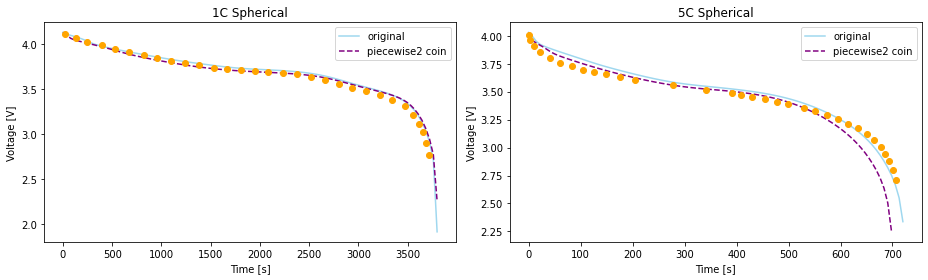

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

# plot the 1C Spherical results
t_sol_So = solutions_So[0]["Time [s]"].entries
t_sol_Sup = solutions_Sup[0]["Time [s]"].entries
t_sol_Sex = solutions_Sex[0]["Time [s]"].entries
t_sol_S4 = solutions_S4[0]["Time [s]"].entries
ax1.plot(t_sol_So, solutions_So[0]["Terminal voltage [V]"](t_sol_So), label="original", alpha=0.8, color="skyblue")
#ax1.plot(t_sol_Sex, solutions_Sex[0]["Terminal voltage [V]"](t_sol_Sex), label="piecewise1", linestyle="--", color="brown")
#ax1.plot(t_sol_Sup, solutions_Sup[0]["Terminal voltage [V]"](t_sol_Sup), label="piecewise2 spherical", alpha=0.8, color="green")
ax1.plot(t_sol_S4, solutions_S4[0]["Terminal voltage [V]"](t_sol_S4), label="piecewise2 coin", linestyle="--", color="purple")
ax1.plot(voltage_data_1C[:,0], voltage_data_1C[:,1], "o", color='orange')
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Voltage [V]")
ax1.set_title("1C Spherical")
ax1.legend(loc="best")

# plot the 5C Spherical results
t_sol_So = solutions_So[1]["Time [s]"].entries
t_sol_Sup = solutions_Sup[1]["Time [s]"].entries
t_sol_Sex = solutions_Sex[1]["Time [s]"].entries
t_sol_S4 = solutions_S4[1]["Time [s]"].entries
ax2.plot(t_sol_So, solutions_So[1]["Terminal voltage [V]"](t_sol_So), label="original", alpha=0.8, color="skyblue")
#ax2.plot(t_sol_Sex, solutions_Sex[1]["Terminal voltage [V]"](t_sol_Sex), label="piecewise1",linestyle="--", color="brown")
#ax2.plot(t_sol_Sup, solutions_Sup[1]["Terminal voltage [V]"](t_sol_Sup), label="piecewise2 spherical", alpha=0.8, color="green")
ax2.plot(t_sol_S4, solutions_S4[1]["Terminal voltage [V]"](t_sol_S4), label="piecewise2 coin", linestyle="--", color="purple")
ax2.plot(voltage_data_5C[:,0], voltage_data_5C[:,1], "o", color='orange')
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Voltage [V]")
ax2.set_title("5C Spherical")
ax2.legend(loc="best")

plt.tight_layout()
#plt.savefig('adjust piecewise spherical new fit')
plt.show()

## Plotting New Chemistry with Coin Geometry (SPMe Only)

In [17]:
coin = {"particle shape":"negative coin"}

In [18]:
# choose DFN
var = pybamm.standard_spatial_vars
model3 = pybamm.lithium_ion. DFN(build=False, options=coin)
# add rho_n
model3.variables.update(
    {
        "rho_n": var.rho_n,
        "rho_n [m]": var.rho_n * model3.param.R_n,
    }
)
# delete r_n
model3.variables.pop('r_n', None)
model3.variables.pop('r_n [m]', None)
model3.build_model()

In [19]:
# choose SPMe
var = pybamm.standard_spatial_vars
model4 = pybamm.lithium_ion. SPMe(build=False, options=coin)
# add rho_n
model4.variables.update(
    {
        "rho_n": var.rho_n,
        "rho_n [m]": var.rho_n * model3.param.R_n,
    }
)
# delete r_n
model4.variables.pop('r_n', None)
model4.variables.pop('r_n [m]', None)
model4.build_model()

In [20]:
parameter_values0c = pybamm.ParameterValues(chemistry=chemistry_new)
parameter_values0c.update({"Current function [A]": "[input]"})
parameter_values0c.update({"Negative particle radius [m]": 4.5e-05})
parameter_values0c.update({"Negative electrode diffusivity [m2.s-1]": "[function]graphite_diffusivity_Ecker2015_coin_original"},
                        path="pybamm/input/parameters/lithium-ion/anodes/" + chemistry_new['anode'])

In [21]:
parameter_values1c = pybamm.ParameterValues(chemistry=chemistry_new)
parameter_values1c.update({"Current function [A]": "[input]"})
parameter_values1c.update({"Negative particle radius [m]": 2.1e-05})
parameter_values1c.update({"Negative electrode diffusivity [m2.s-1]": "[function]graphite_diffusivity_Ecker2015_coin"},
                        path="pybamm/input/parameters/lithium-ion/anodes/" + chemistry_new['anode'])

In [22]:
parameter_values2c = pybamm.ParameterValues(chemistry=chemistry_new)
parameter_values2c.update({"Current function [A]": "[input]"})
parameter_values2c.update({"Negative particle radius [m]": 2.1e-05})
parameter_values2c.update({"Negative electrode diffusivity [m2.s-1]": "[function]graphite_diffusivity_Ecker2015_coin_up"},
                        path="pybamm/input/parameters/lithium-ion/anodes/" + chemistry_new['anode'])

In [23]:
parameter_values3c = pybamm.ParameterValues(chemistry=chemistry_new)
parameter_values3c.update({"Current function [A]": "[input]"})
parameter_values3c.update({"Negative particle radius [m]": 2.1e-05})
parameter_values3c.update({"Negative electrode diffusivity [m2.s-1]": "[function]graphite_diffusivity_Ecker2015_coin_4"},
                        path="pybamm/input/parameters/lithium-ion/anodes/" + chemistry_new['anode'])

In [24]:
var = pybamm.standard_spatial_vars
var_pts_n2 = {
    var.x_n: int(parameter_values0c.evaluate(model3.param.L_n / 1e-6)),
    var.x_s: int(parameter_values0c.evaluate(model3.param.L_s / 1e-6)),
    var.x_p: int(parameter_values0c.evaluate(model3.param.L_p / 1e-6)),
    var.rho_n: int(parameter_values0c.evaluate(model3.param.R_n / 1e-7)),
    var.r_p: int(parameter_values0c.evaluate(model3.param.R_p / 1e-7)),
}

In [25]:
sim_Co =  pybamm.Simulation(model3, parameter_values=parameter_values0c, var_pts=var_pts_n2, geometry=pybamm.battery_geometry(coin_geometry=True))
sim_Cex =  pybamm.Simulation(model3, parameter_values=parameter_values1c, var_pts=var_pts_n2, geometry=pybamm.battery_geometry(coin_geometry=True))
sim_Cup =  pybamm.Simulation(model3, parameter_values=parameter_values2c, var_pts=var_pts_n2, geometry=pybamm.battery_geometry(coin_geometry=True))
sim_C4 =  pybamm.Simulation(model3, parameter_values=parameter_values3c, var_pts=var_pts_n2, geometry=pybamm.battery_geometry(coin_geometry=True))

In [26]:
C_rates = [1, 5]  # C-rates to solve for
capacity = parameter_values0c["Cell capacity [A.h]"]
t_evals = [
    np.linspace(0, 3800, 100), 
    np.linspace(0, 720, 100)
] # times to return the solution at
solutions_Co = [None] * len(C_rates)  # empty list that will hold solutions

# loop over C-rates
for i, C_rate in enumerate(C_rates):
    current = C_rate * capacity
    sim_Co.solve(t_eval=t_evals[i], solver=pybamm.CasadiSolver(mode="fast"),inputs={"Current function [A]": current})
    solutions_Co[i] = sim_Co.solution

In [27]:
C_rates = [1, 5]  # C-rates to solve for
capacity = parameter_values1c["Cell capacity [A.h]"]
t_evals = [
    np.linspace(0, 3800, 100), 
    np.linspace(0, 720, 100)
] # times to return the solution at
solutions_Cex = [None] * len(C_rates)  # empty list that will hold solutions

# loop over C-rates
for i, C_rate in enumerate(C_rates):
    current = C_rate * capacity
    sim_Cex.solve(t_eval=t_evals[i], solver=pybamm.CasadiSolver(mode="fast"),inputs={"Current function [A]": current})
    solutions_Cex[i] = sim_Cex.solution

In [28]:
C_rates = [1, 5]  # C-rates to solve for
capacity = parameter_values2c["Cell capacity [A.h]"]
t_evals = [
    np.linspace(0, 3800, 100), 
    np.linspace(0, 720, 100)
] # times to return the solution at
solutions_Cup = [None] * len(C_rates)  # empty list that will hold solutions

# loop over C-rates
for i, C_rate in enumerate(C_rates):
    current = C_rate * capacity
    sim_Cup.solve(t_eval=t_evals[i], solver=pybamm.CasadiSolver(mode="fast"),inputs={"Current function [A]": current})
    solutions_Cup[i] = sim_Cup.solution

In [29]:
C_rates = [1, 5]  # C-rates to solve for
capacity = parameter_values3c["Cell capacity [A.h]"]
t_evals = [
    np.linspace(0, 3800, 100), 
    np.linspace(0, 720, 100)
] # times to return the solution at
solutions_C4 = [None] * len(C_rates)  # empty list that will hold solutions

# loop over C-rates
for i, C_rate in enumerate(C_rates):
    current = C_rate * capacity
    sim_C4.solve(t_eval=t_evals[i], solver=pybamm.CasadiSolver(mode="fast"),inputs={"Current function [A]": current})
    solutions_C4[i] = sim_C4.solution

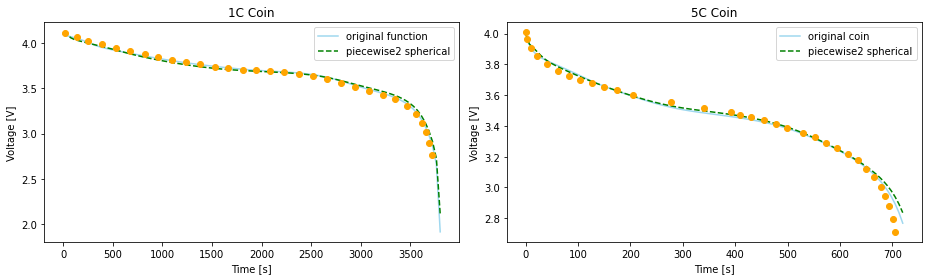

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

# plot the 1C Spherical results
t_sol_Co = solutions_Co[0]["Time [s]"].entries
t_sol_Cex = solutions_Cex[0]["Time [s]"].entries
t_sol_Cup = solutions_Cup[0]["Time [s]"].entries
ax1.plot(t_sol_Co, solutions_Co[0]["Terminal voltage [V]"](t_sol_Co), label="original function", alpha=0.8, color="skyblue")
#ax1.plot(t_sol_Cex, solutions_Cex[0]["Terminal voltage [V]"](t_sol_Cex), label="piecewise1",linestyle="--", color="brown")
ax1.plot(t_sol_Cup, solutions_Cup[0]["Terminal voltage [V]"](t_sol_Cup), label="piecewise2 spherical",linestyle="--", color="green")
ax1.plot(voltage_data_1C[:,0], voltage_data_1C[:,1], "o", color='orange')
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Voltage [V]")
ax1.set_title("1C Coin")
ax1.legend(loc="best")

# plot the 5C Spherical results
t_sol_Co = solutions_Co[1]["Time [s]"].entries
t_sol_Cex = solutions_Cex[1]["Time [s]"].entries
t_sol_Cup = solutions_Cup[1]["Time [s]"].entries
ax2.plot(t_sol_Co, solutions_Co[1]["Terminal voltage [V]"](t_sol_Co), label="original coin", alpha=0.8, color="skyblue")
#ax2.plot(t_sol_Cex, solutions_Cex[1]["Terminal voltage [V]"](t_sol_Cex), label="piecewise1",linestyle="--", color="brown")
ax2.plot(t_sol_Cup, solutions_Cup[1]["Terminal voltage [V]"](t_sol_Cup), label="piecewise2 spherical",linestyle="--", color="green")
ax2.plot(voltage_data_5C[:,0], voltage_data_5C[:,1], "o", color='orange')
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Voltage [V]")
ax2.set_title("5C Coin")
ax2.legend(loc="best")

plt.tight_layout()
#plt.savefig('adjust fit4 exponential coin')
plt.show()

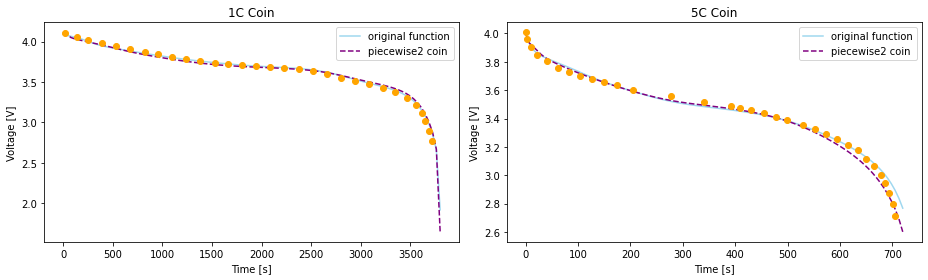

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

# plot the 1C Spherical results
t_sol_Co = solutions_Co[0]["Time [s]"].entries
t_sol_Cex = solutions_Cex[0]["Time [s]"].entries
t_sol_Cup = solutions_Cup[0]["Time [s]"].entries
t_sol_C4 = solutions_C4[0]["Time [s]"].entries
ax1.plot(t_sol_Co, solutions_Co[0]["Terminal voltage [V]"](t_sol_Co), label="original function", alpha=0.8, color="skyblue")
#ax1.plot(t_sol_Cex, solutions_Cex[0]["Terminal voltage [V]"](t_sol_Cex), label="piecewise1",linestyle="--", color="brown")
#ax1.plot(t_sol_Cup, solutions_Cup[0]["Terminal voltage [V]"](t_sol_Cup), label="piecewise2 spherical", alpha=0.8, color="green")
ax1.plot(t_sol_C4, solutions_C4[0]["Terminal voltage [V]"](t_sol_C4), label="piecewise2 coin",linestyle="--", color="purple")
ax1.plot(voltage_data_1C[:,0], voltage_data_1C[:,1], "o", color='orange')
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Voltage [V]")
ax1.set_title("1C Coin")
ax1.legend(loc="best")

# plot the 5C Spherical results
t_sol_Co = solutions_Co[1]["Time [s]"].entries
t_sol_Cex = solutions_Cex[1]["Time [s]"].entries
t_sol_Cup = solutions_Cup[1]["Time [s]"].entries
t_sol_C4 = solutions_C4[1]["Time [s]"].entries
ax2.plot(t_sol_Co, solutions_Co[1]["Terminal voltage [V]"](t_sol_Co), label="original function", alpha=0.8, color="skyblue")
#ax2.plot(t_sol_Cex, solutions_Cex[1]["Terminal voltage [V]"](t_sol_Cex), label="piecewise1",linestyle="--", color="brown")
#ax2.plot(t_sol_Cup, solutions_Cup[1]["Terminal voltage [V]"](t_sol_Cup), label="piecewise2 spherical", alpha=0.8, color="green")
ax2.plot(t_sol_C4, solutions_C4[1]["Terminal voltage [V]"](t_sol_C4), label="piecewise2 coin",linestyle="--", color="purple")
ax2.plot(voltage_data_5C[:,0], voltage_data_5C[:,1], "o", color='orange')
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Voltage [V]")
ax2.set_title("5C Coin")
ax2.legend(loc="best")

plt.tight_layout()
#plt.savefig('adjust piecewise coin new fit')
plt.show()

## Summary

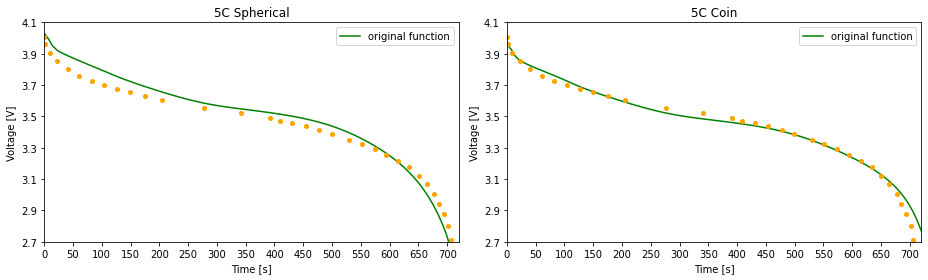

In [78]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

# plot the 5C Spherical results
t_sol_So = solutions_So[1]["Time [s]"].entries
t_sol_Sup = solutions_Sup[1]["Time [s]"].entries
t_sol_Sex = solutions_Sex[1]["Time [s]"].entries
ax1.plot(t_sol_So, solutions_So[1]["Terminal voltage [V]"](t_sol_So), label="original function", color="green")
ax1.plot(voltage_data_5C[:,0], voltage_data_5C[:,1], ".", color='orange', markersize=8)
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Voltage [V]")
ax1.set_title("5C Spherical")
ax1.set_xlim(0,720)
ax1.set_ylim(2.7,4)
ax1.set_yticks(np.arange(2.7,4.2,0.2))
ax1.set_xticks(np.arange(0,750,50))
ax1.legend(loc="best")

# plot the 5C Coin results
t_sol_Co = solutions_Co[1]["Time [s]"].entries
t_sol_Cex = solutions_Cex[1]["Time [s]"].entries
t_sol_Cup = solutions_Cup[1]["Time [s]"].entries
ax2.plot(t_sol_Co, solutions_Co[1]["Terminal voltage [V]"](t_sol_Co), label="original function", color="green")
ax2.plot(voltage_data_5C[:,0], voltage_data_5C[:,1], ".", color='orange', markersize=8)
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Voltage [V]")
ax2.set_title("5C Coin")
ax2.legend(loc="best")
ax2.set_xlim(0,720)
ax2.set_ylim(2.7,4)
ax2.set_yticks(np.arange(2.7,4.2,0.2))
ax2.set_xticks(np.arange(0,750,50))

plt.tight_layout()
#plt.savefig('original')
plt.show()

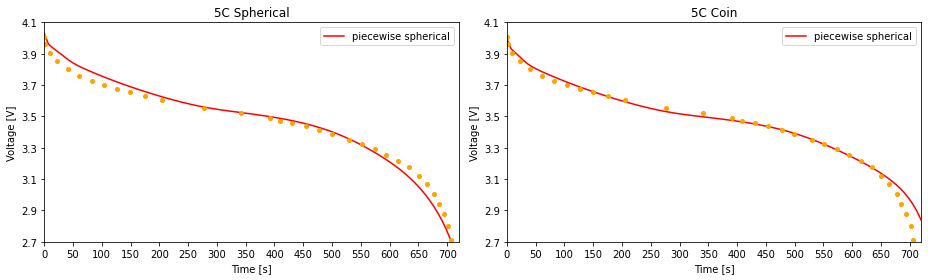

In [79]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

# plot the 5C Spherical results
t_sol_So = solutions_So[1]["Time [s]"].entries
t_sol_Sup = solutions_Sup[1]["Time [s]"].entries
t_sol_Sex = solutions_Sex[1]["Time [s]"].entries
ax1.plot(t_sol_Sup, solutions_Sup[1]["Terminal voltage [V]"](t_sol_Sup), label="piecewise spherical", color="red")
ax1.plot(voltage_data_5C[:,0], voltage_data_5C[:,1], ".", color='orange', markersize=8)
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Voltage [V]")
ax1.set_title("5C Spherical")
ax1.set_xlim(0,720)
ax1.set_ylim(2.7,4)
ax1.set_yticks(np.arange(2.7,4.2,0.2))
ax1.set_xticks(np.arange(0,750,50))
ax1.legend(loc="best")

# plot the 5C Coin results
t_sol_Co = solutions_Co[1]["Time [s]"].entries
t_sol_Cex = solutions_Cex[1]["Time [s]"].entries
t_sol_Cup = solutions_Cup[1]["Time [s]"].entries
ax2.plot(t_sol_Cup, solutions_Cup[1]["Terminal voltage [V]"](t_sol_Cup), label="piecewise spherical", color="red")
ax2.plot(voltage_data_5C[:,0], voltage_data_5C[:,1], ".", color='orange', markersize=8)
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Voltage [V]")
ax2.set_title("5C Coin")
ax2.set_xlim(0,720)
ax2.set_ylim(2.7,4)
ax2.set_yticks(np.arange(2.7,4.2,0.2))
ax2.set_xticks(np.arange(0,750,50))
ax2.legend(loc="best")

plt.tight_layout()
#plt.savefig('piecewise spherical')
plt.show()

2020-08-21 12:04:16,627 - [WARNING] processed_variable.__call__(510): Calling variable outside interpolation range (returns 'nan')


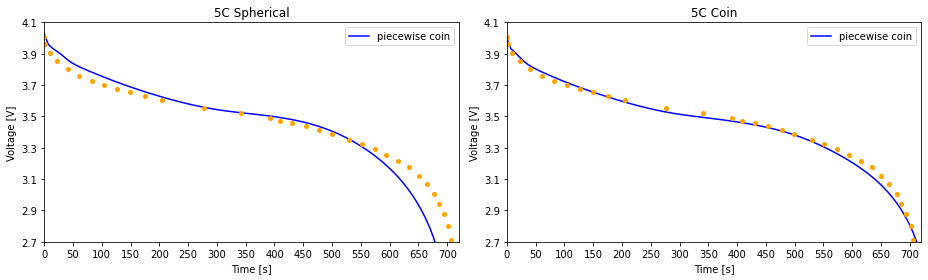

In [80]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

# plot the 5C Spherical results
t_sol_So = solutions_So[1]["Time [s]"].entries
t_sol_Sup = solutions_Sup[1]["Time [s]"].entries
t_sol_Sex = solutions_Sex[1]["Time [s]"].entries
t_sol_S4 = solutions_S4[1]["Time [s]"].entries
ax1.plot(t_sol_S4, solutions_S4[1]["Terminal voltage [V]"](t_sol_S4), label="piecewise coin", color="blue")
ax1.plot(voltage_data_5C[:,0], voltage_data_5C[:,1], ".", color='orange', markersize=8)
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Voltage [V]")
ax1.set_title("5C Spherical")
ax1.set_xlim(0,720)
ax1.set_ylim(2.7,4)
ax1.set_yticks(np.arange(2.7,4.2,0.2))
ax1.set_xticks(np.arange(0,750,50))
ax1.legend(loc="best")

# plot the 5C Coin results
t_sol_Co = solutions_Co[1]["Time [s]"].entries
t_sol_Cex = solutions_Cex[1]["Time [s]"].entries
t_sol_Cup = solutions_Cup[1]["Time [s]"].entries
t_sol_C4 = solutions_C4[1]["Time [s]"].entries
ax2.plot(t_sol_C4, solutions_C4[1]["Terminal voltage [V]"](t_sol_C4), label="piecewise coin", color="blue")
ax2.plot(voltage_data_5C[:,0], voltage_data_5C[:,1], ".", color='orange', markersize=8)
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Voltage [V]")
ax2.set_title("5C Coin")
ax2.set_xlim(0,720)
ax2.set_ylim(2.7,4)
ax2.set_yticks(np.arange(2.7,4.2,0.2))
ax2.set_xticks(np.arange(0,750,50))
ax2.legend(loc="best")

plt.tight_layout()
#plt.savefig('piecewise coin')
plt.show()